In [17]:
# For streaming
import sys
version = sys.version_info
if version.major < 3 or (version.major == 3 and version.minor < 10):
    raise RuntimeError("This script requires Python 3.10 or higher")
import os
from typing import Iterable

from fileStreams import getFileJsonStream
from utils import FileProgressLog

# For processing
import gensim
from gensim.models import Word2Vec
import re
import logging
from tqdm import tqdm
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
    
import datetime
import random
import numpy as np
import html
import unicodedata
import glob



filePathforDemocrats = r"datasets/democrats_comments.zst"
filePathforRepublican = r"datasets/Republican_comments.zst"
recursive = False


def processFile(path, party, output_dir, without_stopwords=True, seed=23):
    print(f"Processing file {path}")
    
    # # Download necessary NLTK resources
    # nltk.download('stopwords', quiet=True)
    # nltk.download('wordnet', quiet=True)
    # nltk.download('punkt', quiet=True)
    # nltk.download('averaged_perceptron_tagger', quiet=True)  # For POS tagging
    
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Create empty lists for each time period
    chunks = {
        "before_2016": []
    }
    
    # Track counts
    counts = {period: 0 for period in chunks.keys()}
    
    POS_CACHE = {}
    LEMMA_CACHE = {}
    
    with open(path, "rb") as f:
        jsonStream = getFileJsonStream(path, f)
        if jsonStream is None:
            print(f"Skipping unknown file {path}")
            return
        for row in tqdm(jsonStream, desc="Processing comments"):
            if "body" not in row or "created_utc" not in row:
                continue
            
            # Get the comment text and timestamp
            text = row["body"]
            created_timestamp = row["created_utc"]
            author = row["author"]
            if author in {"AutoModerator", "election_info_bot"}:
                continue
            
            # Convert timestamp to year
            year = datetime.datetime.fromtimestamp(int(created_timestamp)).year
            
            # Determine which chunk this comment belongs to
            chunk_key = None
            if year <= 2016:
                chunk_key = "before_2016"
            else:
                continue
            
            # Process text
            # Handle HTML entities
            text = html.unescape(text)
            
            # Unicode normalization
            text = unicodedata.normalize('NFKD', text)
            
            # Remove URLs and Markdown formatting
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
            text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
            text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
            text = re.sub(r'\*(.*?)\*', r'\1', text)
            
            # Remove subreddit and user references
            text = re.sub(r'/r/\w+', '', text)
            text = re.sub(r'r/\w+', '', text)
            text = re.sub(r'/u/\w+', '', text)
            text = re.sub(r'u/\w+', '', text)
            
            # Basic text cleaning
            text = re.sub("[^A-Za-z]+", ' ', text).lower()
            
            # Remove single letters (except 'i')
            text = re.sub(r'\b([a-hj-z])\b', '', text)
            
            # Tokenize
            words = text.split()
            
            # Skip empty comments
            if not words:
                continue
            
            # Filter stop words
            if without_stopwords:
                words_to_tag = []
                for word in words:
                    if word not in stop_words:
                        words_to_tag.append(word)
            else:
                words_to_tag = words[:]
                
            if not words_to_tag:
                continue
            
            # POS Cache
            uncached_words = []
            for word in words_to_tag:
                if word not in POS_CACHE:
                    uncached_words.append(word)

            if uncached_words:
                tagged_uncached = nltk.pos_tag(uncached_words)
                for word, tag in tagged_uncached:
                    POS_CACHE[word] = tag

            processed_words = []
            for word in words_to_tag:
                tag = POS_CACHE[word]
                # Convert to wordnet_pos
                if tag.startswith('J'):
                    wordnet_pos = 'a'
                elif tag.startswith('V'):
                    wordnet_pos = 'v'
                elif tag.startswith('N'):
                    wordnet_pos = 'n'
                elif tag.startswith('R'):
                    wordnet_pos = 'r'
                else:
                    wordnet_pos = 'n'

                lemma_key = (word, wordnet_pos)
                if lemma_key in LEMMA_CACHE:
                    lemma = LEMMA_CACHE[lemma_key]
                else:
                    lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
                    LEMMA_CACHE[lemma_key] = lemma

                processed_words.append(lemma)

            if processed_words:
                chunks[chunk_key].append(processed_words)
                counts[chunk_key] += 1
                
    # Print statistics
    print("\n=== Comment Counts by Period ===")
    for period, count in counts.items():
        print(f"{period}: {count} comments")
        
    # Extract bigrams from each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            # Build bigram model
            phrases = Phrases(comments, min_count=5, threshold=10)
            bigram_model = Phraser(phrases)
            
            # Apply bigram model to create comments with bigrams
            bigrammed_comments = [bigram_model[comment] for comment in comments]
            chunks[period] = bigrammed_comments
        
    # Train a Word2Vec model for each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            print(f"\n=== Training Word2Vec for {period} ({len(comments)} comments) ===")
            
            # Initialize and train model
            model = Word2Vec(
                vector_size=300,
                window=5,
                min_count=5,
                workers=16,
                seed=seed
            )
            
            # Build vocabulary
            model.build_vocab(comments)
            print(f"Vocabulary size: {len(model.wv.index_to_key)}")
            
            # Train the model
            model.train(
                comments, 
                total_examples=len(comments), 
                epochs=5
            )
            
            # Save the model
            model_path = f"{output_dir}/{party}_{period}_10.model"
            model.save(model_path)
            print(f"Model saved to {model_path}")
            
            
def main():
    seed = 23
    random.seed(seed)
    np.random.seed(seed)
    output_dir = "models/model_d4"
    os.makedirs(output_dir, exist_ok=True)
    processFile(filePathforDemocrats, "democrats_full", without_stopwords=True, output_dir=output_dir)
    processFile(filePathforRepublican, "republican_full", without_stopwords=True, output_dir=output_dir)
    print("Done :>")

if __name__ == "__main__":
    main()


Processing file datasets/democrats_comments.zst


Processing comments: 51424it [00:02, 19950.99it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\cyyua\AppData\Local\Temp\ipykernel_22012\2595363165.py", line 230, in <module>
    main()
  File "C:\Users\cyyua\AppData\Local\Temp\ipykernel_22012\2595363165.py", line 225, in main
    processFile(filePathforDemocrats, "democrats_full", without_stopwords=True, output_dir=output_dir)
  File "C:\Users\cyyua\AppData\Local\Temp\ipykernel_22012\2595363165.py", line None, in processFile
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2194, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cyyua\DS\word_e

In [ ]:
import os
import pickle
import datetime
import re
import html
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from fileStreams import getFileJsonStream
from collections import defaultdict
import glob
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import logging

# For NLP processing and modeling
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
# Initialize global resources once
STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

# POS tag cache to avoid redundant tagging
POS_CACHE = {}
# Lemma cache to avoid redundant lemmatization
LEMMA_CACHE = {}

def get_wordnet_pos(tag):
    """Convert NLTK POS tag to WordNet POS tag"""
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default as noun

def preprocess_text(text, lemmatize=True, without_stopwords=True):
    """Preprocess Reddit text content with optimized NLTK operations"""
    # Handle HTML entities
    text = html.unescape(text)
    
    # Unicode normalization
    text = unicodedata.normalize('NFKD', text)
    
    # Remove URLs and Markdown formatting
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
    text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
    text = re.sub(r'\*(.*?)\*', r'\1', text)
    
    # Remove subreddit and user references
    text = re.sub(r'/r/\w+', '', text)
    text = re.sub(r'r/\w+', '', text)
    text = re.sub(r'/u/\w+', '', text)
    text = re.sub(r'u/\w+', '', text)
    
    # Basic text cleaning
    text = re.sub("[^A-Za-z]+", ' ', text).lower()
    
    # Remove single letters (except 'i')
    text = re.sub(r'\b([a-hj-z])\b', '', text)
    
    words = text.split()
    if not words:
        return []
        
    # Lemmatization
    if lemmatize:
        if without_stopwords:
            stop_words = STOP_WORDS
        else:
            stop_words = set()

        # Process words in a single batch for better performance
        words_to_tag = []
        for word in words:
            if word not in stop_words:
                words_to_tag.append(word)
        
        if not words_to_tag:
            return []
            
        # First check our caches
        uncached_words = []
        for word in words_to_tag:
            if word not in POS_CACHE:
                uncached_words.append(word)
        
        # Only perform POS tagging on words not in cache
        if uncached_words:
            tagged_uncached = nltk.pos_tag(uncached_words)
            # Update cache with new tags
            for word, tag in tagged_uncached:
                POS_CACHE[word] = tag
        
        processed_words = []
        
        # Process each word with cached information
        for word in words_to_tag:
            tag = POS_CACHE[word]
            wordnet_pos = get_wordnet_pos(tag)
            
            # Check lemma cache first
            lemma_key = (word, wordnet_pos)
            if lemma_key in LEMMA_CACHE:
                lemma = LEMMA_CACHE[lemma_key]
            else:
                lemma = LEMMATIZER.lemmatize(word, pos=wordnet_pos)
                LEMMA_CACHE[lemma_key] = lemma
                
            processed_words.append(lemma)
                
        return processed_words
    
    return words

def process_and_save_comments(path, subreddit, without_stopwords=True, batch_size=1000000):
    """Process comments and save in batches"""
    print(f"Processing file: {path}")
    
    # Batch processing counters
    batch_count = 0
    batch_number = 1
    total_count = 0
    
    # Create output directory
    output_dir = f"processed_comments_d4/{subreddit}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Create data structure for comments
    comments_batch = []
    
    print(f"Starting to process {subreddit} comments...")
    with open(path, "rb") as f:
        jsonStream = getFileJsonStream(path, f)
        if jsonStream is None:
            print(f"Unable to read file {path}")
            return
        
        for row in tqdm(jsonStream, desc=f"Processing {subreddit} comments"):
            if "body" not in row or "created_utc" not in row or "author" not in row or "id" not in row:
                continue
                
            author = row["author"]
            if author in {"AutoModerator", "election_info_bot"}:
                continue
            
            comment_id = row["id"]
            text = row["body"]
            created_timestamp = row["created_utc"]
            date = datetime.datetime.fromtimestamp(int(created_timestamp))
            
            # Process text with optimized functions
            processed_words = preprocess_text(text, lemmatize=True, without_stopwords=without_stopwords)
            
            if processed_words:
                # Save processed comment with metadata
                comment_data = {
                    "comment_id": comment_id,
                    "author": author,
                    "date": date.strftime("%Y-%m-%d"),
                    "timestamp": created_timestamp,
                    "processed_text": processed_words,  # Original order preserved
                    "original": text
                }
                
                comments_batch.append(comment_data)
                batch_count += 1
                
            # Check if we need to save the current batch
            if batch_count >= batch_size:
                print(f"\nReached {batch_size} comments, saving batch {batch_number}...")
                
                # Save batch directly without filtering
                save_path = f"{output_dir}/{subreddit}_batch{batch_number}.pkl"
                with open(save_path, "wb") as out_file:
                    pickle.dump(comments_batch, out_file)
                
                print(f"Saved {len(comments_batch)} comments to {save_path}")
                
                # Reset batch data
                comments_batch = []
                batch_count = 0
                batch_number += 1
                total_count += batch_size
                
                # Report cache stats
                print(f"POS tag cache size: {len(POS_CACHE)} words")
                print(f"Lemma cache size: {len(LEMMA_CACHE)} word-POS pairs")
    
    # Process any remaining comments
    if batch_count > 0:
        print(f"\nSaving remaining {batch_count} comments...")
        
        # Save batch
        save_path = f"{output_dir}/{subreddit}_batch{batch_number}.pkl"
        with open(save_path, "wb") as out_file:
            pickle.dump(comments_batch, out_file)
        
        print(f"Saved {len(comments_batch)} comments to {save_path}")
        total_count += batch_count
    
    print(f"\nCompleted processing {subreddit} comments!")
    print(f"Total comments saved: {total_count}")
    print(f"Final POS tag cache size: {len(POS_CACHE)} words")
    print(f"Final lemma cache size: {len(LEMMA_CACHE)} word-POS pairs")

def main():
    """Main function"""
    random.seed(23)
    np.random.seed(23)
    # Define data file paths
    files = {
        "democrats": r"datasets/democrats_comments.zst",
        "republican": r"datasets/Republican_comments.zst",
    }
    
    # Choose subreddit to process
    subreddit_to_process = "democrats"  # Change this to process other subreddits

    # Ensure output directory exists
    os.makedirs(f"processed_comments_d4/{subreddit_to_process}", exist_ok=True)

    if subreddit_to_process in files:
        process_and_save_comments(  
            files[subreddit_to_process],
            subreddit_to_process,
            without_stopwords=True,
            batch_size=1000000
        )
    else:
        print(f"Subreddit not found: {subreddit_to_process}")
        print(f"Available subreddits: {', '.join(files.keys())}")
        
if __name__ == "__main__":
    main()

Processing file: datasets/democrats_comments.zst
Starting to process democrats comments...


Processing democrats comments: 1040579it [00:32, 36063.35it/s]


Reached 1000000 comments, saving batch 1...
Saved 1000000 comments to processed_comments_d4/democrats/democrats_batch1.pkl


Processing democrats comments: 1047187it [00:34, 6695.49it/s] 

POS tag cache size: 109808 words
Lemma cache size: 109808 word-POS pairs


Processing democrats comments: 2011525it [01:00, 33262.33it/s]



Saving remaining 935437 comments...
Saved 935437 comments to processed_comments_d4/democrats/democrats_batch2.pkl

Completed processing democrats comments!
Total comments saved: 1935437
Final POS tag cache size: 144691 words
Final lemma cache size: 144691 word-POS pairs


In [29]:
import os
import pickle
import datetime
import re
import html
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from fileStreams import getFileJsonStream
from collections import defaultdict
import glob
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import logging

def get_date_from_comment(comment):
    """Extract date from a comment dictionary"""
    try:
        return datetime.datetime.strptime(comment["date"], "%Y-%m-%d").date()
    except (KeyError, ValueError):
        try:
            return datetime.datetime.fromtimestamp(int(comment["timestamp"])).date()
        except (KeyError, ValueError):
            return None

def get_period(date):
    """Determine which time period a date belongs to"""
    if date is None:
        return None
    year = date.year
    if year <= 2016:
        return "before_2016"
    return None

def build_bigram_model(comments, min_count=5):
    """Build a bigram model for the given comments"""
    sentences = []
    for comment in comments:
        if "processed_text" in comment:
            sentences.append(comment["processed_text"])
    phrases = Phrases(sentences, min_count=min_count, threshold=10)
    return Phraser(phrases)

def apply_bigrams(comments, bigram_model):
    """Apply bigram model to comments"""
    processed = []
    for comment in comments:
        if "processed_text" in comment:
            processed.append(bigram_model[comment["processed_text"]])
    return processed

def create_or_update_model(comments, vector_size, window, min_count, workers, sg, epochs, existing_model=None):
    """Create a new model or update an existing one"""
    if existing_model is None:
        model = Word2Vec(
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers,
            sg=sg,
            seed=23
        )
        model.build_vocab(comments)
        print(f"Vocabulary size: {len(model.wv.index_to_key)}")
    else:
        model = existing_model
        model.build_vocab(comments, update=True)
        print(f"Vocabulary size: {len(model.wv.index_to_key)}")
    model.train(comments, total_examples=len(comments), epochs=epochs)
    return model

def save_model(model, subreddit, period, model_dir, is_interim=False):
    """Save model to disk"""
    if is_interim:
        path = f"{model_dir}/interim/{subreddit}_chunk_{period}_interim.model"
    else:
        path = f"{model_dir}/{subreddit}_chunk_{period}_10.model"
    model.save(path)
    print(f"Model saved to {path}")

def build_models_for_subreddit(
    subreddit,
    base_data_dir="processed_comments",
    model_dir="models/model_d4",
    vector_size=300,
    window=5,
    min_count=5,
    epochs=5,
    workers=16,
    sg=0,
    min_comments_to_train=10000,
    chunk_size=1000000
):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(f"{model_dir}/interim", exist_ok=True)
    time_periods = ["before_2016"]
    models = {period: None for period in time_periods}
    bigram_models = {period: None for period in time_periods}

    # Find all pickle files
    pattern = f"{base_data_dir}/{subreddit}/{subreddit}_batch*.pkl"
    pickle_files = sorted(glob.glob(pattern))
    if not pickle_files:
        print(f"No pickle files found for {subreddit} in {base_data_dir}/{subreddit}/")
        return

    comments_by_period = {period: [] for period in time_periods}

    for file_path in pickle_files:
        print(f"Processing {file_path}")
        try:
            with open(file_path, 'rb') as f:
                comments = pickle.load(f)
            print(f"Loaded {len(comments)} comments from {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

        for comment in comments:
            date = get_date_from_comment(comment)
            period = get_period(date)
            if period:
                comments_by_period[period].append(comment)

        for period in time_periods:
            period_comments = comments_by_period[period]
            while len(period_comments) >= chunk_size:
                print(f"Processing chunk of {chunk_size} comments for {period}")
                chunk = period_comments[:chunk_size]
                period_comments = period_comments[chunk_size:]

                bigram_model = build_bigram_model(chunk)
                bigram_models[period] = bigram_model
                processed_chunk = apply_bigrams(chunk, bigram_model)

                if len(processed_chunk) > min_comments_to_train:
                    model = create_or_update_model(processed_chunk, vector_size, window, min_count, workers, sg, epochs, models[period])
                    models[period] = model
                    save_model(model, subreddit, period, model_dir, is_interim=True)
            comments_by_period[period] = period_comments

    # Process any remaining comments
    for period, remaining_comments in comments_by_period.items():
        if len(remaining_comments) > min_comments_to_train:
            print(f"Processing final {len(remaining_comments)} comments for {period}")
            bigram_model = build_bigram_model(remaining_comments)
            bigram_models[period] = bigram_model
            processed_chunk = apply_bigrams(remaining_comments, bigram_model)
            model = create_or_update_model(
                processed_chunk, vector_size, window, min_count, workers, sg, epochs, models[period]
            )
            models[period] = model
            save_model(model, subreddit, period, model_dir, is_interim=False)
        else:
            print(f"Skipping final {len(remaining_comments)} comments for {period} (less than minimum required)")

    # Save final models
    for period, model in models.items():
        if model is not None:
            save_model(model, subreddit, period, model_dir, is_interim=False)
    print(f"Completed building models for {subreddit}")

def main():
    random.seed(23)
    np.random.seed(23)
    subreddits = ["democrats", "republican"]
    for subreddit in subreddits:
        build_models_for_subreddit(
            subreddit,
            base_data_dir="processed_comments_d4",
            model_dir="models/model_d4",
            vector_size=300,
            window=5,
            min_count=5,
            epochs=5,
            workers=16,
            sg=0,
            min_comments_to_train=10000,
            chunk_size=1000000
        )

if __name__ == "__main__":
    main()

Processing processed_comments_d4/democrats\democrats_batch1.pkl
Loaded 1000000 comments from processed_comments_d4/democrats\democrats_batch1.pkl
Processing processed_comments_d4/democrats\democrats_batch2.pkl
Loaded 935437 comments from processed_comments_d4/democrats\democrats_batch2.pkl
Processing final 127372 comments for before_2016
Vocabulary size: 22382
Model saved to models/model_d4/democrats_chunk_before_2016_10.model
Model saved to models/model_d4/democrats_chunk_before_2016_10.model
Completed building models for democrats
Processing processed_comments_d4/republican\republican_batch1.pkl
Loaded 1000000 comments from processed_comments_d4/republican\republican_batch1.pkl
Processing processed_comments_d4/republican\republican_batch2.pkl
Loaded 292460 comments from processed_comments_d4/republican\republican_batch2.pkl
Processing final 263823 comments for before_2016
Vocabulary size: 33050
Model saved to models/model_d4/republican_chunk_before_2016_10.model
Model saved to models


Comparing models:
before_2016: Common vocabulary between republican and democrats: 17583 words
Results saved to output/d4/republican_democrats_full_before_2016.csv

Analysis complete


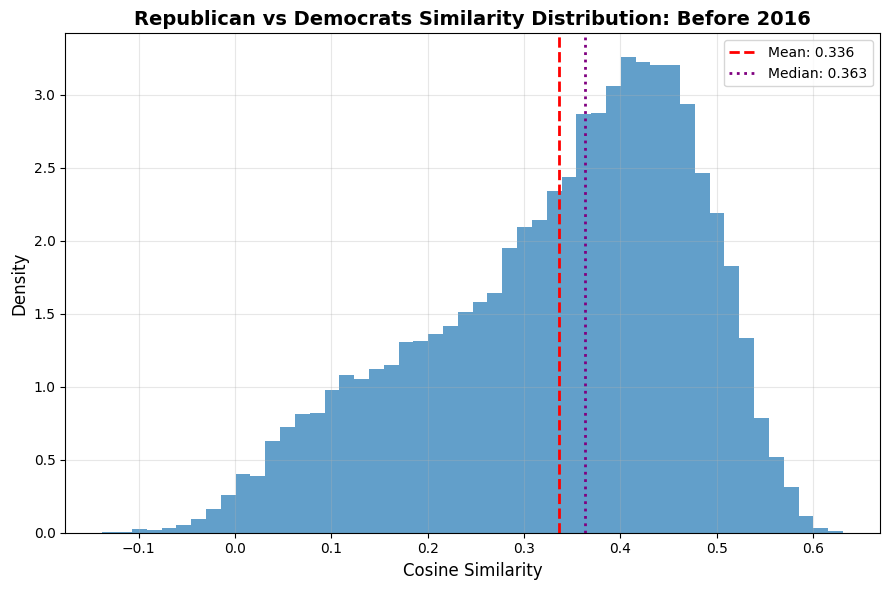

In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

random.seed(23)
np.random.seed(23) 

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

# Democrats vs Republicans
democrats_full_before_2016 = gensim.models.Word2Vec.load("models/model_d4/democrats_full_before_2016_1.model")
republican_full_before_2016 = gensim.models.Word2Vec.load("models/model_d4/republican_full_before_2016_1.model")
# democrats_chunk_before_2016 = gensim.models.Word2Vec.load("models/model_d4/democrats_chunk_before_2016.model")
# republican_chunk_before_2016 = gensim.models.Word2Vec.load("models/model_d4/republican_chunk_before_2016.model")


# Define output directory
output_dir = "output/d4"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016

compare_subreddit_embeddings_by_period(
    republican_full_before_2016, 
    democrats_full_before_2016,
    "republican", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/republican_democrats_full_before_2016_1.csv"
)


print("\nAnalysis complete")


def analyze_similarity_distributions(df_before_2016, subreddit1, subreddit2):
    """Plot cosine similarity distribution for before 2016 only"""
    plt.figure(figsize=(9, 6))
    plt.hist(df_before_2016['similarity'], bins=50, alpha=0.7, density=True, color='#1f77b4')

    mean_sim = df_before_2016['similarity'].mean()
    median_sim = df_before_2016['similarity'].median()

    plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sim:.3f}')
    plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2, label=f'Median: {median_sim:.3f}')

    plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: Before 2016', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"output/d4/{subreddit1}_{subreddit2}_full_similarity_distributions_before_2016.png")
    plt.show()



# Run the analysis
# Read the CSV files
republican_democrats_full_before_2016 = pd.read_csv("output/d4/republican_democrats_full_before_2016.csv")


analyze_similarity_distributions(
    republican_democrats_full_before_2016, 
    "Republican", 
    "Democrats"
    )



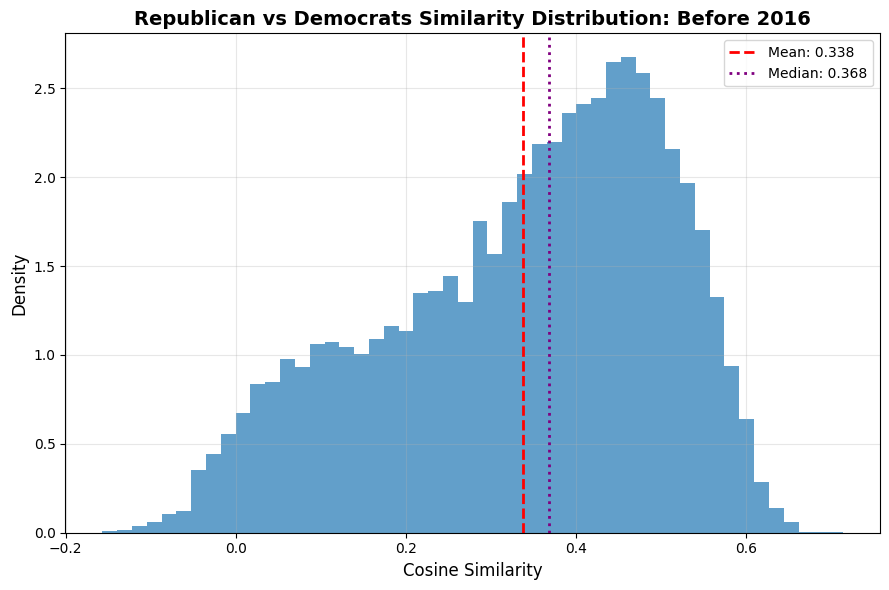

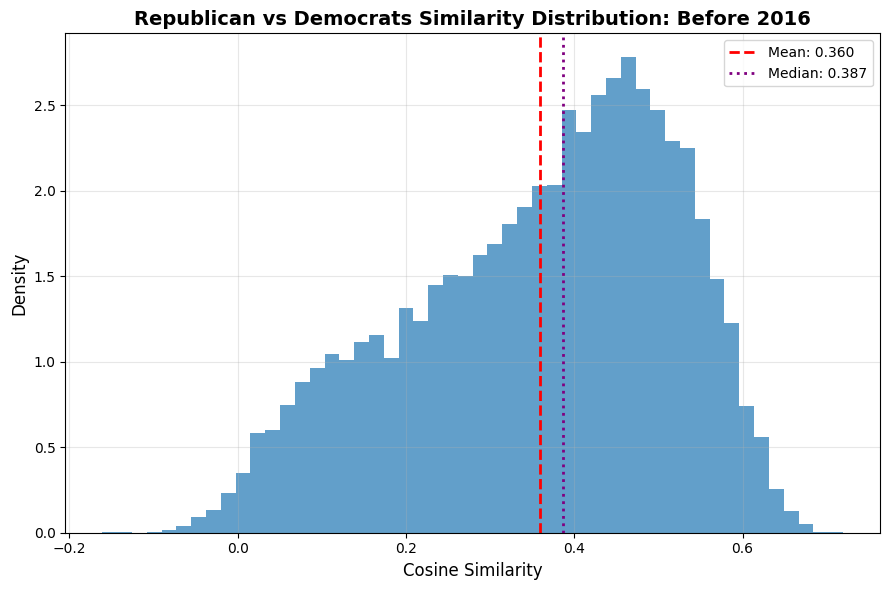

In [10]:
def analyze_similarity_distributions(df_before_2016, subreddit1, subreddit2):
    """Plot cosine similarity distribution for before 2016 only"""
    plt.figure(figsize=(9, 6))
    plt.hist(df_before_2016['similarity'], bins=50, alpha=0.7, density=True, color='#1f77b4')

    mean_sim = df_before_2016['similarity'].mean()
    median_sim = df_before_2016['similarity'].median()

    plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sim:.3f}')
    plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2, label=f'Median: {median_sim:.3f}')

    plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: Before 2016', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



# Run the analysis
# Read the CSV files
republican_democrats_full_before_2016 = pd.read_csv("output/d4/republican_democrats_full_before_2016_1.csv")
republican_democrats_chunk_before_2016 = pd.read_csv("output/d4/republican_democrats_chunk_before_2016_1.csv")


analyze_similarity_distributions(
    republican_democrats_full_before_2016, 
    "Republican", 
    "Democrats"
    )


analyze_similarity_distributions(
    republican_democrats_chunk_before_2016, 
    "Republican", 
    "Democrats"
    )

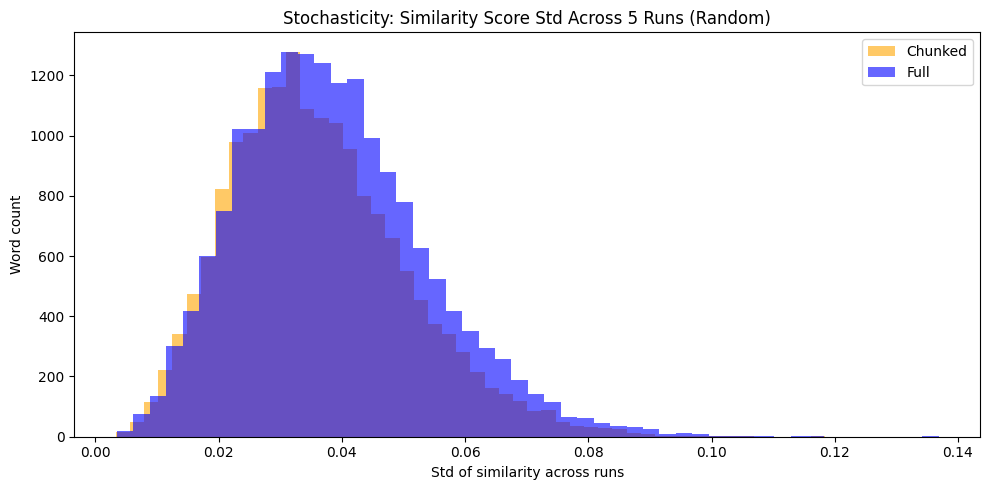

Chunked mean std: 0.03615739682725839
Full mean std: 0.038536426738554244
Chunked median std: 0.03444377913722674
Full median std: 0.03703101007238252


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Helper to load all runs for a given prefix
def load_similarity_runs(prefix, n_runs=5):
    dfs = []
    for i in range(1, n_runs+1):
        df = pd.read_csv(f"{prefix}_{i}.csv")
        df = df.set_index('word')
        dfs.append(df)
    # Join on word
    all_sims = pd.concat([df['similarity'].rename(f'run_{i+1}') for i, df in enumerate(dfs)], axis=1)
    return all_sims

# Load chunk and full runs
chunk_sims = load_similarity_runs("output/d4/republican_democrats_chunk_before_2016", n_runs=5)
full_sims = load_similarity_runs("output/d4/republican_democrats_full_before_2016", n_runs=5)

# Compute statistics
chunk_sims['mean'] = chunk_sims.mean(axis=1)
chunk_sims['std'] = chunk_sims.std(axis=1)
full_sims['mean'] = full_sims.mean(axis=1)
full_sims['std'] = full_sims.std(axis=1)

# Merge for comparison
merged = pd.DataFrame({
    'chunk_mean': chunk_sims['mean'],
    'chunk_std': chunk_sims['std'],
    'full_mean': full_sims['mean'],
    'full_std': full_sims['std']
}).dropna()

# Plot std distributions
plt.figure(figsize=(10,5))
plt.hist(merged['chunk_std'], bins=50, alpha=0.6, label='Chunked', color='orange')
plt.hist(merged['full_std'], bins=50, alpha=0.6, label='Full', color='blue')
plt.xlabel('Std of similarity across runs')
plt.ylabel('Word count')
plt.title('Stochasticity: Similarity Score Std Across 5 Runs (Random)')
plt.legend()
plt.tight_layout()
plt.savefig("output/d4/stochasticity_chunk_vs_full_random.png")
plt.show()

# Print summary statistics
print("Chunked mean std:", merged['chunk_std'].mean())
print("Full mean std:", merged['full_std'].mean())
print("Chunked median std:", merged['chunk_std'].median())
print("Full median std:", merged['full_std'].median())

# Save merged stats for further analysis
merged.to_csv("output/d4/stochasticity_chunk_vs_full_random.csv")

In [ ]:
import pandas as pd
import numpy as np

def get_run_means(prefix, n_runs=5):
    means = []
    for i in range(1, n_runs+1):
        df = pd.read_csv(f"{prefix}_{i}.csv")
        means.append(df['similarity'].mean())
    return means

chunk_means = get_run_means("output/d4/republican_democrats_chunk_before_2016", n_runs=5)
full_means = get_run_means("output/d4/republican_democrats_full_before_2016", n_runs=5)

print("Chunked 5 runs mean:", np.mean(chunk_means))
print("Chunked 5 runs std :", np.std(chunk_means))
print("Full 5 runs mean  :", np.mean(full_means))
print("Full 5 runs std   :", np.std(full_means))

Chunked 5 runs mean: 0.3536028418592325
Chunked 5 runs std : 0.005007993869590508
Full 5 runs mean  : 0.35500201356362227
Full 5 runs std   : 0.013149753476625255


In [16]:
import pandas as pd
import numpy as np

def get_top_bottom_words(prefix, n_runs=5, percent=0.01):
    word_sets_top = []
    word_sets_bottom = []
    for i in range(1, n_runs+1):
        df = pd.read_csv(f"{prefix}_{i}.csv")
        df = df.set_index('word')
        n = max(1, int(len(df) * percent))
        top_words = set(df['similarity'].nlargest(n).index)
        bottom_words = set(df['similarity'].nsmallest(n).index)
        word_sets_top.append(top_words)
        word_sets_bottom.append(bottom_words)
    return word_sets_top, word_sets_bottom

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

def mean_jaccard(word_sets):
    n = len(word_sets)
    sims = []
    for i in range(n):
        for j in range(i+1, n):
            sims.append(jaccard_similarity(word_sets[i], word_sets[j]))
            # print(f"Jaccard similarity between run {i+1} and run {j+1}: {sims[-1]:.4f}")
    return np.mean(sims) if sims else 0

chunk_top, chunk_bottom = get_top_bottom_words("output/d4/republican_democrats_chunk_before_2016", n_runs=5, percent=0.01)
full_top, full_bottom = get_top_bottom_words("output/d4/republican_democrats_full_before_2016", n_runs=5, percent=0.01)

print("Chunked top 1% mean Jaccard:", mean_jaccard(chunk_top))
print("Chunked bottom 1% mean Jaccard:", mean_jaccard(chunk_bottom))
print("Full top 1% mean Jaccard:", mean_jaccard(full_top))
print("Full bottom 1% mean Jaccard:", mean_jaccard(full_bottom))

Chunked top 1% mean Jaccard: 0.22493040689642657
Chunked bottom 1% mean Jaccard: 0.12164240001383594
Full top 1% mean Jaccard: 0.1843480897433602
Full bottom 1% mean Jaccard: 0.11379508807473104


In [18]:
import pandas as pd
import numpy as np

def get_run_means(prefix, n_runs=5):
    means = []
    for i in range(1, n_runs+1):
        df = pd.read_csv(f"{prefix}_{i+5}.csv")
        means.append(df['similarity'].mean())
    return means

chunk_means = get_run_means("output/d4/republican_democrats_chunk_before_2016", n_runs=5)
full_means = get_run_means("output/d4/republican_democrats_full_before_2016", n_runs=5)

print("Chunked 5 runs mean:", np.mean(chunk_means))
print("Chunked 5 runs std :", np.std(chunk_means))
print("Full 5 runs mean  :", np.mean(full_means))
print("Full 5 runs std   :", np.std(full_means))

Chunked 5 runs mean: 0.3218799993250886
Chunked 5 runs std : 0.009388521958032104
Full 5 runs mean  : 0.3158173655687992
Full 5 runs std   : 0.007960876931056729
